In [24]:
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

import pandas as pd

In [25]:
def create_filepaths(numbers, pre_path):
    padded_numbers = []
    file_ext = '.dat'
    for n in numbers:
        if n <= 9:
            padded_numbers = np.append(padded_numbers, pre_path + '00' + str(n) + file_ext)
        elif n <= 99:
            padded_numbers = np.append(padded_numbers, pre_path + '0' + str(n) + file_ext)
        else:
            padded_numbers = np.append(padded_numbers, pre_path + str(n) + file_ext)
    return padded_numbers

## Model specifics

In [77]:
date = '100417'
file_numbers = [16]
params = ['Amplitude', 'Mean', 'Std dev', 'Offset']

In [78]:
def model(time, amp, mean, std_dev, offset):
    return ( amp * np.exp( -(time-mean)**2 / (2*(std_dev)**2) ) ) + offset

In [79]:
def fit_guess_default():
    amp_guess = 1E-10
    mean_guess = 37.0155
    std_dev_guess = 0.001
    offset_guess = -0.8E-9
    return [amp_guess, mean_guess, std_dev_guess, offset_guess]

## Model fitting

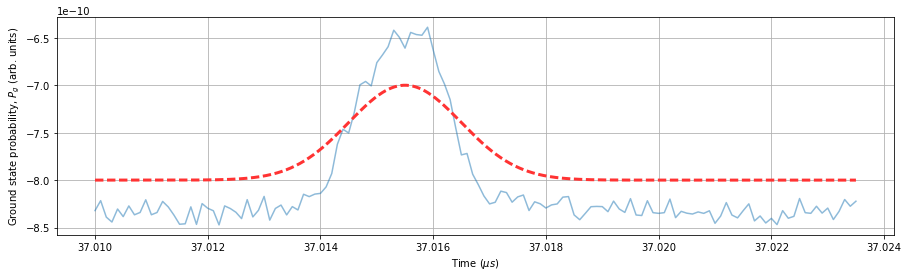

In [82]:
def fit_model_test(date, file_numbers, params=[], guess=fit_guess_default(), crop=[0,0], local=False):
    if local:
        file_path = "SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    else:
        file_path = "C:\data\\" + date + "\\SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)

    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    timesSet = False
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1]
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4]
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        if timesSet == True:
            min_time = np.min([min_time, np.min(time)])
            max_time = np.max([max_time, np.max(time)])
        else:
            min_time = np.min(time)
            max_time = np.max(time)
            timesSet = True
        
        plt.plot(time, p_g, alpha=0.5)

    timeSteps = np.linspace(min_time, max_time, 1000)

    plt.plot(timeSteps, model(timeSteps, *guess), '--', lw=3, color=[1.0,0.2,0.2], label='Fit guess')
    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Ground state probability, $P_g$ (arb. units)')
    plt.grid()

fit_model_test(date, file_numbers, crop=[100,120])

# Fit sinusoidal waveforms

,Amplitude,Amplitude error,Mean,Mean error,Std dev,Std dev error,Offset,Offset error
0,1.953391e-10,3.107460e-12,37.01548,0.000013,0.000749,0.000014,-8.326909e-10,9.213157e-13


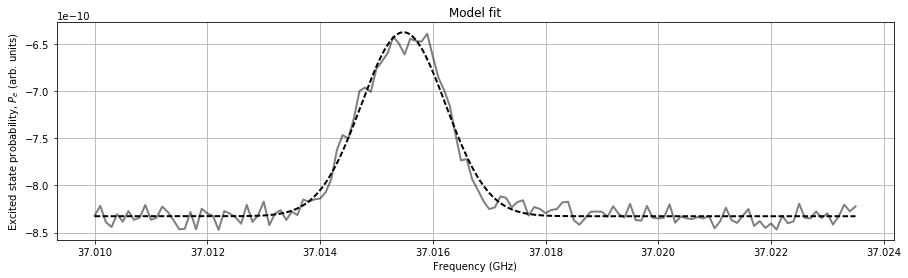

In [83]:
def fit_model(date, file_numbers, params, guess=fit_guess_default(), crop=[0,0], local=False):
    if local:
        file_path = "SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    else:
        file_path = "C:\data\\" + date + "\\SR" + date + "_"
        full_paths = create_filepaths(file_numbers, file_path)
    
    matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)
    colors = ['k','r','g','b','c','m','y']
        
    popts = []
    perrs = []
    df = pd.DataFrame(columns = [*params, *[p + ' error' for p in params]])
    timesSet = False
    for i, path in enumerate(full_paths):
        data = np.loadtxt(path)
        time = data[:,1]
        time = time[crop[0]:len(time)-crop[1]]
        p_g = data[:,4]
        p_g = p_g[crop[0]:len(p_g)-crop[1]]
        
        if timesSet == True:
            min_time = np.min([min_time, np.min(time)])
            max_time = np.max([max_time, np.max(time)])
        else:
            min_time = np.min(time)
            max_time = np.max(time)
            timesSet = True

        popt,pcov = curve_fit(model, time, p_g, p0=guess)
        perr = np.sqrt(np.diag(pcov))
        popts = np.concatenate((popts, popt), axis=0)
        perrs = np.concatenate((perrs, perr), axis=0)

        df.loc[i] = [*popt, *perr]
        matplotlib.rcParams['figure.figsize'] = (15.0, 4.0)

        timeSteps = np.linspace(min_time, max_time, 1000)
        p_g_fit = model(timeSteps, *popt)
        plt.plot(time, p_g, '-', lw=2, color=colors[np.mod(i, len(colors))], alpha=0.5)
        plt.plot(timeSteps, p_g_fit, '--', lw=2, color=colors[np.mod(i, len(colors))], alpha=1.0)

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Excited state probability, $P_e$ (arb. units)')
    plt.title('Model fit')
    plt.grid()
    
    popts = np.reshape(popts, [len(file_numbers), len(params)])
    perrs = np.reshape(perrs, [len(file_numbers), len(params)])

    columns = [*list(np.array([[p, p + ' error'] for p in params]).flatten())]
    return df[columns]
    
df = fit_model(date, file_numbers, params, crop=[100,120])
df